In [1]:
import os
import control
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

# linearized state space and parameters.

In [2]:
Z_alpha = -1.05273
Z_delta = -0.0343
M_alpha = -2.3294
M_q = -1.03341
M_delta = -1.1684
V = 329.127
w_a = 2*math.pi*13
damping_ratio = 0.6
T = 0.1
A1 = np.array([[Z_alpha, V*Z_alpha, 0, V*Z_delta],[M_alpha/(V*Z_alpha), M_q, (M_delta-M_alpha*Z_delta/Z_alpha), 0],
               [0, 0, 0, 1], [0, 0, -w_a**2, -2*damping_ratio*w_a]])
B1 = np.array([[0],[0],[0],[w_a]])
C1 = np.array([1,0,0,0])
D1 = 0
sys_cont = control.ss(A1,B1,C1,D1) # Continuous time
sys_discrete = control.c2d(sys_cont,T)
A_d = sys_discrete.A
B_d = sys_discrete.B
C_d = sys_discrete.C
D_d = sys_discrete.D
num_steps = 50


# Task 2.1
## Tune an LQR controller for the continuous-time system

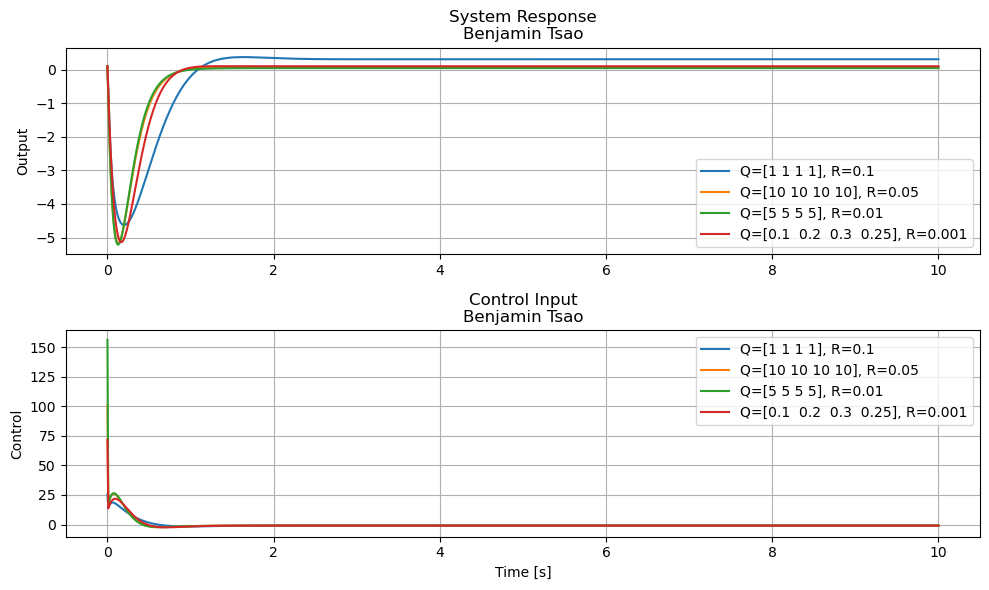

In [3]:
import numpy as np
import control
import matplotlib.pyplot as plt
Z_alpha = -1.05273
Z_delta = -0.0343
M_alpha = -2.3294
M_q = -1.03341
M_delta = -1.1684
V = 329.127
w_a = 2*math.pi*13
damping_ratio = 0.6
T = 0.1
A1 = np.array([[Z_alpha, V*Z_alpha, 0, V*Z_delta],[M_alpha/(V*Z_alpha), M_q, (M_delta-M_alpha*Z_delta/Z_alpha), 0],
               [0, 0, 0, 1], [0, 0, -w_a**2, -2*damping_ratio*w_a]])
B1 = np.array([[0],[0],[0],[w_a]])
C1 = np.array([1,0,0,0])
D1 = 0

def compute_response(Q, R, sys_cont, A1, B1, C1, D1, t, x0):
    # Compute LQR gain
    K_lqr, _, _ = control.lqr(sys_cont, Q, R)

    # Closed-loop dynamics
    Acl = A1 - B1 * K_lqr
    sys_cont_cl = control.ss(Acl, B1, C1, D1)

    # Step response
    t, y, x_state = control.step_response(sys_cont_cl, T=t, X0=x0, return_x=True) 

    # Compute the control action over time
    u = -np.dot(K_lqr, x_state)
    return y, u[0,:]

# Simulation parameters
t = np.linspace(0, 10, 1000)
x0 = np.array([[0.1],[0.1],[0.1],[0.1]])
#x0 = np.array([0.1, 0, 0.1, 0])

# Define a list of Q and R matrices for which you want to plot responses
Q_list = [
    np.diag([1, 1, 1, 1]),
    np.diag([10, 10, 10, 10]),
    np.diag([5,5,5,5]),
    np.diag([0.1,0.2,0.3,0.25])
  
]
R_list = [
    np.array([[0.1]]),
    np.array([[0.05]]),
    np.array([[0.01]]),
    np.array([[0.001]]),]

# Plot
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

for Q, R in zip(Q_list, R_list):
    y, u = compute_response(Q, R, sys_cont, A1, B1, C1, D1, t, x0)
    ax1.plot(t, y, label=f'Q={np.diag(Q)}, R={R[0,0]}')
    ax2.plot(t, u, label=f'Q={np.diag(Q)}, R={R[0,0]}')

ax1.set_title('System Response\nBenjamin Tsao')
ax1.set_ylabel('Output')
ax1.grid()
ax1.legend()

ax2.set_title('Control Input\nBenjamin Tsao')
ax2.set_ylabel('Control')
ax2.set_xlabel('Time [s]')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


 # Task 2.2 and 2.3 
 ## Derive the Kalman filter
 ## LQG

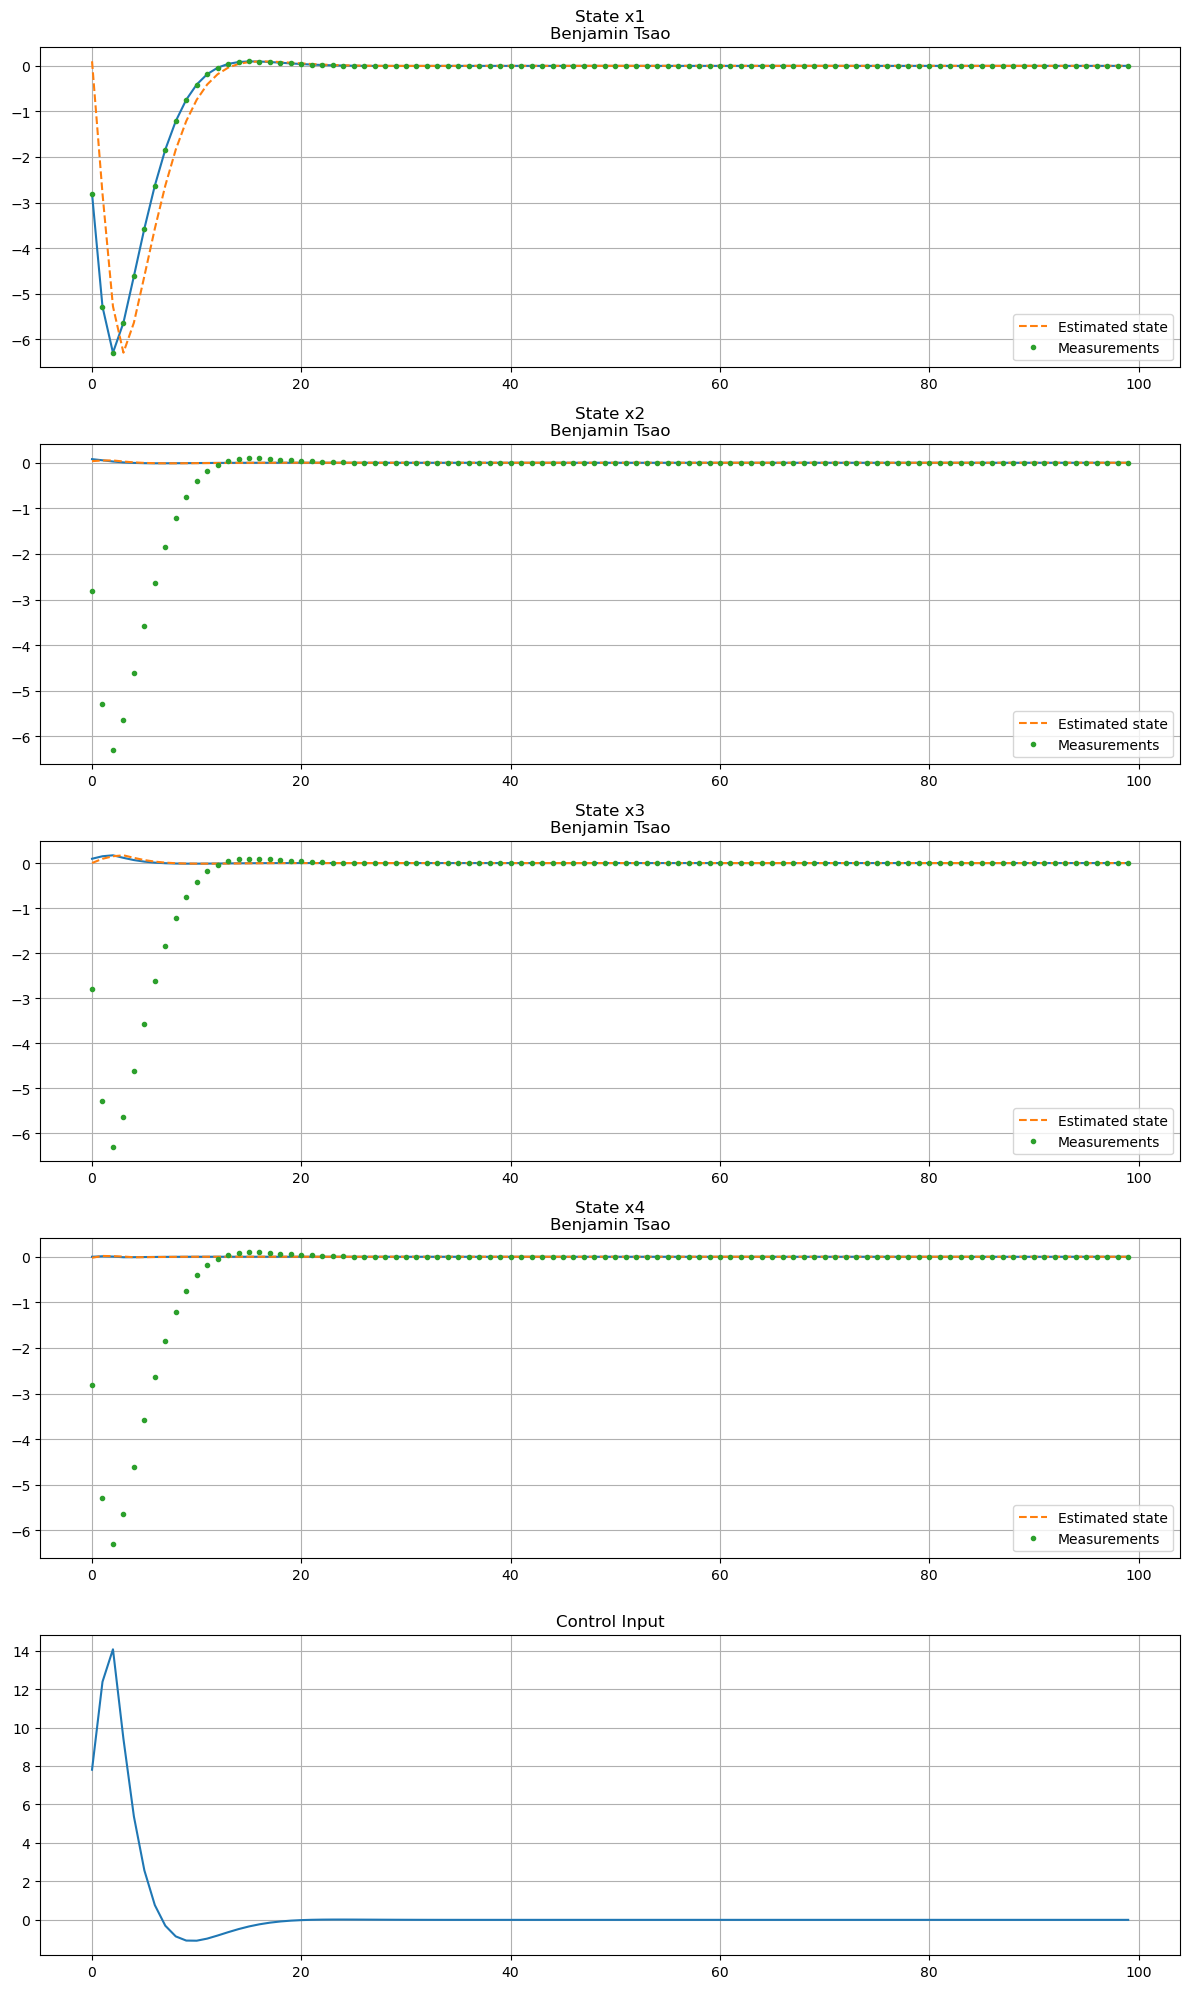

In [4]:
import numpy as np
import control
import math
import matplotlib.pyplot as plt

# Given system parameters
Z_alpha = -1.05273
Z_delta = -0.0343
M_alpha = -2.3294
M_q = -1.03341
M_delta = -1.1684
V = 329.127
w_a = 2*math.pi*13
damping_ratio = 0.6
T = 0.1

A1 = np.array([[Z_alpha, V*Z_alpha, 0, V*Z_delta],
               [M_alpha/(V*Z_alpha), M_q, (M_delta-M_alpha*Z_delta/Z_alpha), 0],
               [0, 0, 0, 1], [0, 0, -w_a**2, -2*damping_ratio*w_a]])
B1 = np.array([[0],[0],[0],[w_a]])
C1 = np.array([[1,0,0,0]])
D1 = 0

# Convert continuous system to discrete-time system
sys_disc = control.c2d(control.ss(A1, B1, C1, D1), T)

# Design LQR controller
Q = np.diag([1,1,1,1])  # state cost matrix
R = 0.1         # control cost
K, _, _ = control.dlqr(sys_disc.A, sys_disc.B, Q, R)

# Kalman Filter initialization
x_hat = np.zeros((4, 1))  # state estimate
P = np.eye(4)  # covariance matrix
Q_kf = np.eye(4) * 0.01  # process noise
R_kf = np.array([[0.1]])  # measurement noise

def kf(y, u):
    global x_hat, P, sys_disc, Q_kf, R_kf

    # Prediction
    x_hat_pred = np.dot(sys_disc.A, x_hat) + np.dot(sys_disc.B, u)
    P_pred = np.dot(np.dot(sys_disc.A, P), sys_disc.A.T) + Q_kf

    # Update
    #P = P_pred - np.dot(np.dot(K_kf, sys_disc.C), P_pred)
    # y = Hx
    # S = H P H.T + R_kf
    # L = P H.T S^-1, kalman filter gain L
    # x = x + L(y-Hx)
    # P = (I - LH) * P
    H = sys_disc.C
    S = H.dot(P_pred).dot(H.T) + R_kf
    L = np.dot(P_pred, np.dot(H.T, np.linalg.inv(S))) 
    x_hat = x_hat_pred+ L.dot(y-H.dot(x_hat_pred))
    P = (np.eye(4) - L.dot(H)).dot(P_pred)

    return x_hat

# Initial conditions
x0 = np.array([[0.1],[0.1],[0.1],[0.1]])

# x_hat = x0 + np.random.randn(4,1)*1.0 # Add some noise
x_hat =x0
# Lists to store system history for plotting
states_hist = []
controls_hist = []
measurements_hist = []
estimates_hist = []  # to store the Kalman filter estimates

# Simulating the closed-loop system with KF and LQR
y_meas = np.dot(sys_disc.C, x0) + np.dot(sys_disc.D, np.array([[0]]))  # initial measurement
u = np.array([[0]])       # initial control

for t in range(100):
    # Kalman Filter for state estimation
    x_est = kf(y_meas, u)

    # LQR control
    u = -np.dot(K, x_est)

    # Simulate the system
    x0 = np.dot(sys_disc.A, x0) + np.dot(sys_disc.B, u)
    # y_meas = np.dot(sys_disc.C, x0) + np.dot(sys_disc.D, u) + np.random.randn(1, 1) * 0.1  # Add noise to estimate the error
    y_meas = np.dot(sys_disc.C, x0) + np.dot(sys_disc.D, u)
    # Store values for plotting
    states_hist.append(x0.flatten())
    estimates_hist.append(x_est.flatten())  # store the Kalman filter estimates
    controls_hist.append(u.flatten())
    measurements_hist.append(y_meas.flatten())

# Plotting the results
plt.figure(figsize=(12, 20))

# Change list to number
states_hist = np.array(states_hist)
controls_hist = np.array(controls_hist)
measurements_hist = np.array(measurements_hist)



# Plot states
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(states_hist[:, i])
    plt.plot(np.array(estimates_hist)[:, i], '--', label='Estimated state')
    plt.plot(measurements_hist, 'o', markersize=3, label='Measurements')
    plt.legend()
    plt.title(f'State x{i+1}\nBenjamin Tsao')
    plt.grid(True)


# Plot control
plt.subplot(5, 1, 5)
plt.plot(controls_hist)
plt.title('Control Input')
plt.grid(True)

plt.tight_layout()
plt.show()


# Task 2.4
### LQG with process and output noise

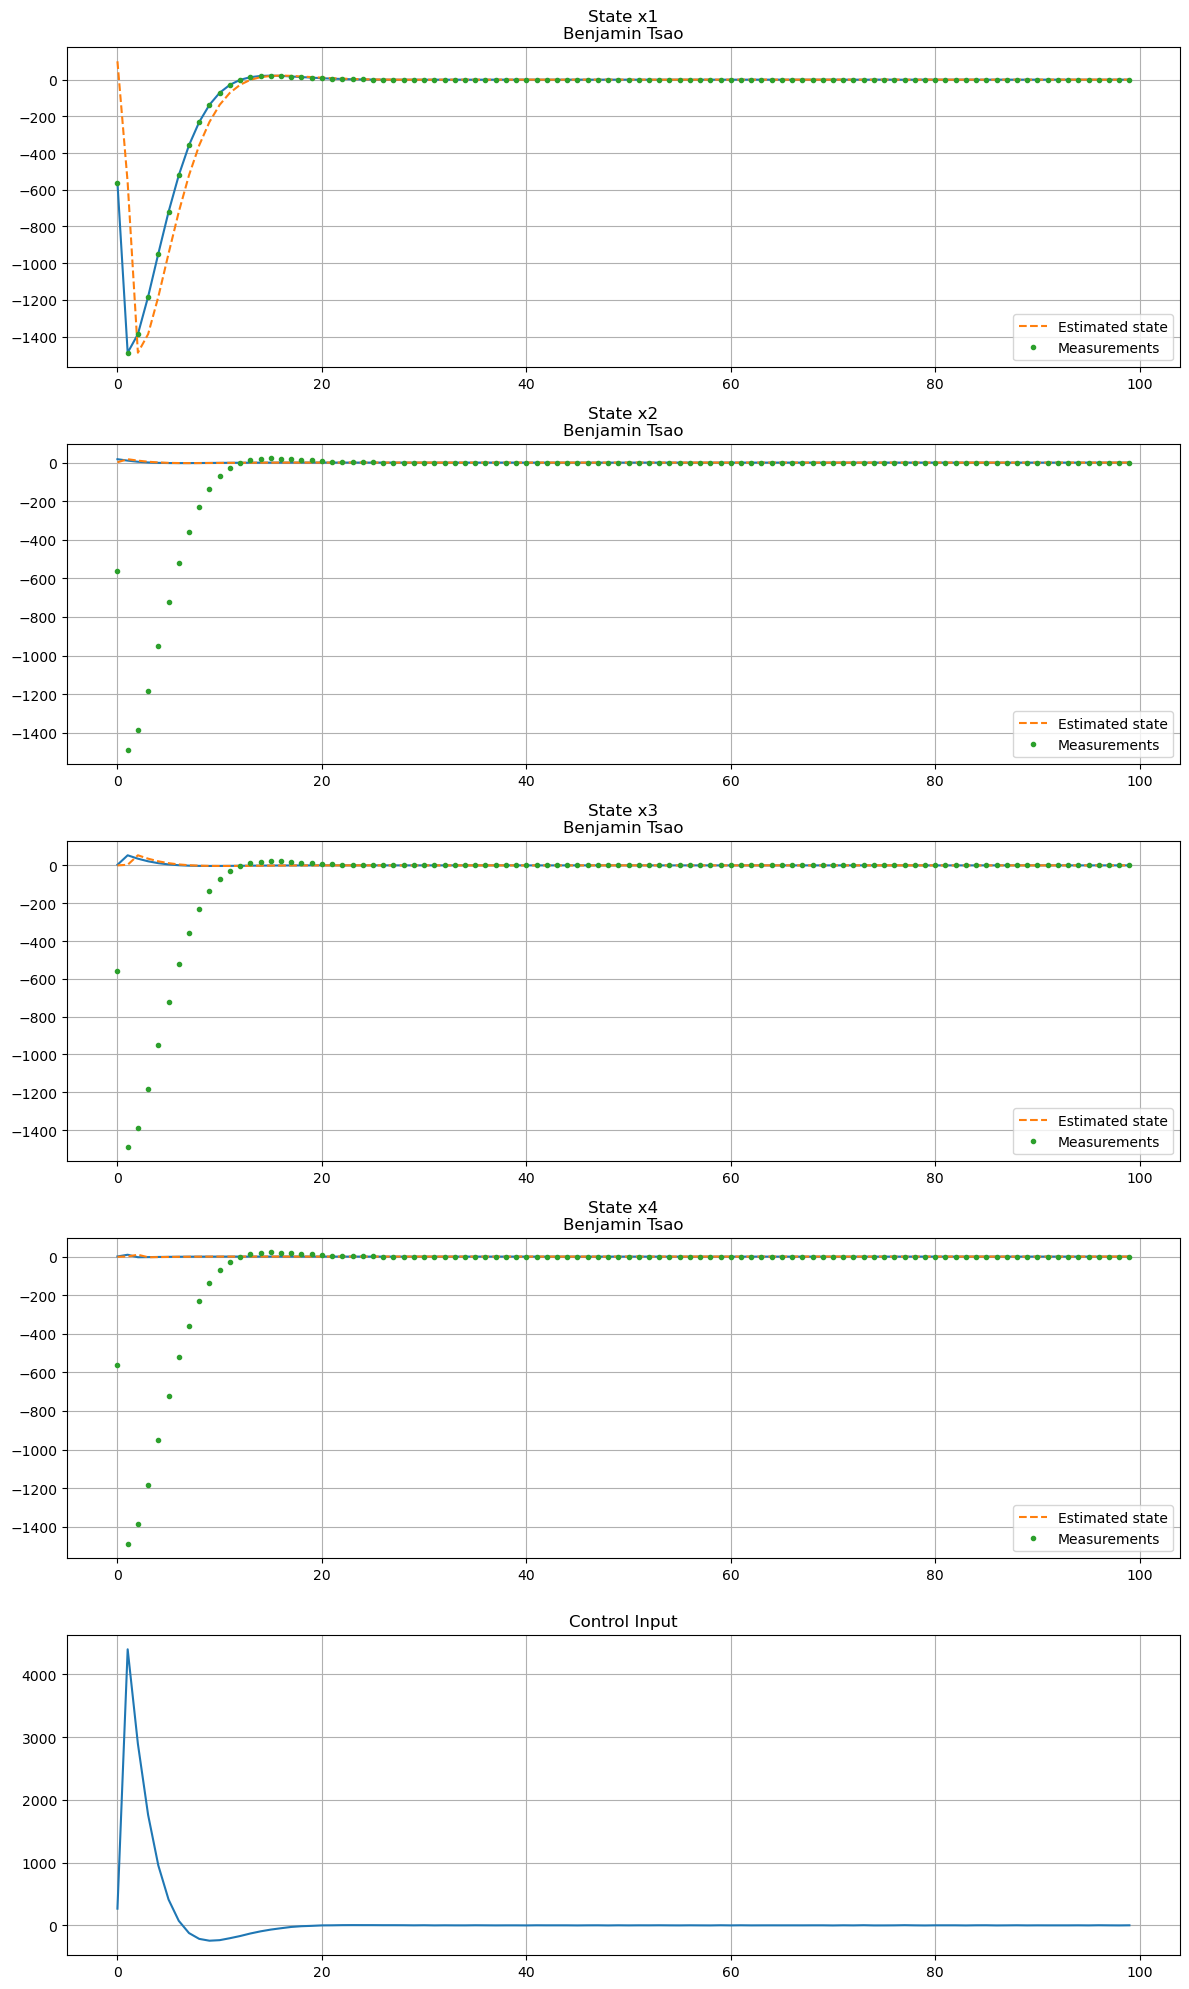

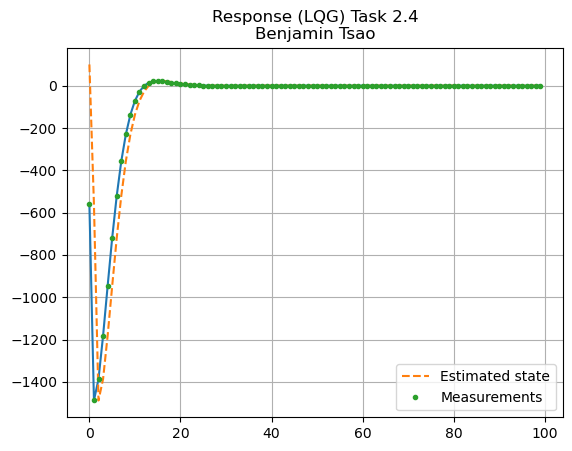

In [6]:
import numpy as np
import control
import math
import matplotlib.pyplot as plt

# Given system parameters
Z_alpha = -1.05273
Z_delta = -0.0343
M_alpha = -2.3294
M_q = -1.03341
M_delta = -1.1684
V = 329.127
w_a = 2*math.pi*13
damping_ratio = 0.6
T = 0.1

A1 = np.array([[Z_alpha, V*Z_alpha, 0, V*Z_delta],
               [M_alpha/(V*Z_alpha), M_q, (M_delta-M_alpha*Z_delta/Z_alpha), 0],
               [0, 0, 0, 1], [0, 0, -w_a**2, -2*damping_ratio*w_a]])
B1 = np.array([[0],[0],[0],[w_a]])
C1 = np.array([[1,0,0,0]])
D1 = 0

# Convert continuous system to discrete-time system
sys_disc = control.c2d(control.ss(A1, B1, C1, D1), T)

# Design LQR controller
Q = np.diag([1,1,1,1])  # state cost matrix
R = 0.1         # control cost
K, _, _ = control.dlqr(sys_disc.A, sys_disc.B, Q, R)

# Kalman Filter initialization
x_hat = np.zeros((4, 1))  # state estimate
P = np.eye(4)  # covariance matrix
Q_kf = np.eye(4) * 0.01  # process noise
R_kf = np.array([[0.001]])  # measurement noise
process_noise_std = 0.01  
output_noise_std = 0.1    


def kf(y, u):
    global x_hat, P, sys_disc, Q_kf, R_kf

    # Prediction
    x_hat_pred = np.dot(sys_disc.A, x_hat) + np.dot(sys_disc.B, u)
    P_pred = np.dot(np.dot(sys_disc.A, P), sys_disc.A.T) + Q_kf

    # Update
    #P = P_pred - np.dot(np.dot(K_kf, sys_disc.C), P_pred)
    # y = Hx
    # S = H P H.T + R_kf
    # L = P H.T S^-1, kalman filter gain L
    # x = x + L(y-Hx)
    # P = (I - LH) * P
    H = sys_disc.C
    S = H.dot(P_pred).dot(H.T) + R_kf
    L = np.dot(P_pred, np.dot(H.T, np.linalg.inv(S))) 
    x_hat = x_hat_pred+ L.dot(y-H.dot(x_hat_pred))
    P = (np.eye(4) - L.dot(H)).dot(P_pred)

    return x_hat

# Initial conditions
x0 = np.array([[100],[20],[0.05],[0.1]])

# x_hat = x0 + np.random.randn(4,1)*1.0 # Add some noise
x_hat =x0
# Lists to store system history for plotting
states_hist = []
controls_hist = []
measurements_hist = []
estimates_hist = []  # to store the Kalman filter estimates

# Simulating the closed-loop system with KF and LQR
y_meas = np.dot(sys_disc.C, x0) + np.dot(sys_disc.D, np.array([[0]]))  # initial measurement
u = np.array([[0]])       # initial control

for t in range(100):
    # Kalman Filter for state estimation
    x_est = kf(y_meas, u)

    # LQR control
    u = -np.dot(K, x_est)

    # Simulate the system with process noise 
    process_noise = np.random.randn(4,1)*process_noise_std
    x0 = np.dot(sys_disc.A, x0) + np.dot(sys_disc.B, u)
    
    # Generate the output with output noise
    output_noise = np.random.randn(1,1)*output_noise_std
    y_meas = np.dot(sys_disc.C, x0) + np.dot(sys_disc.D, u) + output_noise # Add noise to estimate the error
    
    # Store values for plotting
    states_hist.append(x0.flatten())
    estimates_hist.append(x_est.flatten())  # store the Kalman filter estimates
    controls_hist.append(u.flatten())
    measurements_hist.append(y_meas.flatten())

# Plotting the results
plt.figure(figsize=(12, 20))

# Change list to number
states_hist = np.array(states_hist)
controls_hist = np.array(controls_hist)
measurements_hist = np.array(measurements_hist)





# Plot states
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(states_hist[:, i])
    plt.plot(np.array(estimates_hist)[:, i], '--', label='Estimated state')
    plt.plot(measurements_hist, 'o', markersize=3, label='Measurements')
    plt.legend()
    plt.title(f'State x{i+1}\nBenjamin Tsao')
    plt.grid(True)


# Plot control
plt.subplot(5, 1, 5)
plt.plot(controls_hist)
plt.title('Control Input')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(states_hist[:,0])
plt.plot(np.array(estimates_hist)[:, 0], '--', label='Estimated state')
plt.plot(measurements_hist, 'o', markersize=3, label='Measurements')
plt.legend()
plt.title('Response (LQG) Task 2.4\nBenjamin Tsao')
plt.grid(True)

### LQR

C:\Users\elseo\AppData\Local\Temp\ipykernel_18380\380712685.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = -np.dot(K_lqr, x_state[:, i-1])
C:\Users\elseo\AppData\Local\Temp\ipykernel_18380\380712685.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = np.dot(C1, x_state[:, i]) + output_noise_std*np.random.randn()
C:\Users\elseo\AppData\Local\Temp\ipykernel_18380\380712685.py:30: RuntimeWarning: invalid value encountered in add
  x_state[:, i] = np.dot(Acl, x_state[:, i-1]) + np.dot(Bd, [u[i]]) + noise


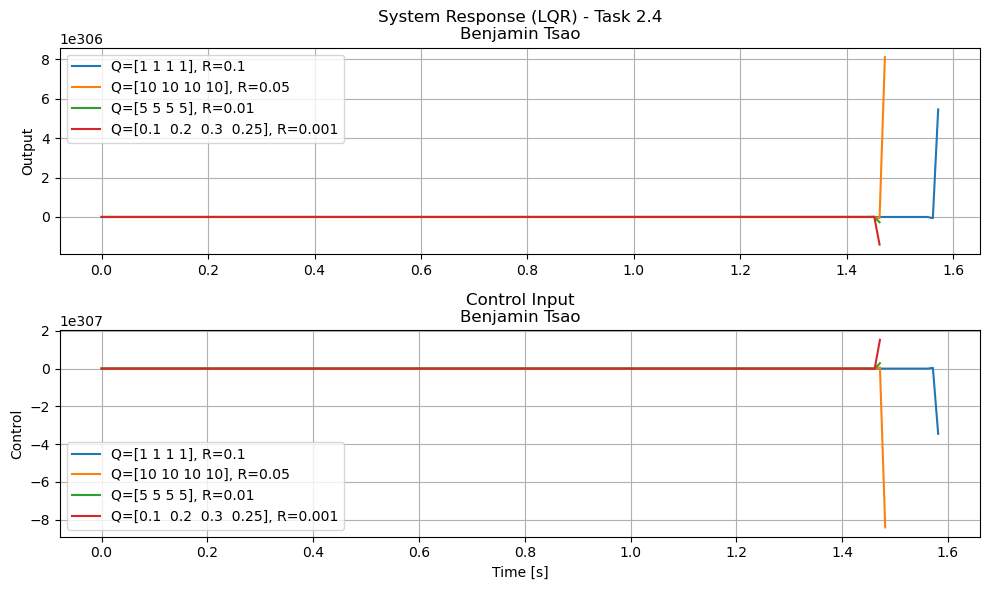

In [15]:
#Inject process noise and output noise

def compute_response(Q, R, sys_cont, A1, B1, C1, D1, t, x0, process_noise_std, output_noise_std):
    dt = t[1] - t[0]
    sys_disc = control.c2d(sys_cont, dt)  # Convert to discrete-time system

    # Extract the discrete-time system matrices
    Ad, Bd, _, _ = sys_disc.A, sys_disc.B, sys_disc.C, sys_disc.D
    
    # Compute LQR gain for the discrete system
    K_lqr, _, _ = control.dlqr(Ad, Bd, Q, R)
    
    # Closed-loop dynamics in discrete-time
    Acl = A1 - B1 @ K_lqr

    # Allocate space for y and u
    y = np.zeros_like(t)
    u = np.zeros_like(t)
    x_state = np.zeros((len(A1), len(t)))
    x_state[:, 0] = x0.flatten()

    for i in range(1, len(t)):
        noise = np.random.randn(4, ) * process_noise_std
        u[i] = -np.dot(K_lqr, x_state[:, i-1])
        x_state[:, i] = np.dot(Acl, x_state[:, i-1]) + np.dot(Bd, [u[i]]) + noise
        y[i] = np.dot(C1, x_state[:, i]) + output_noise_std*np.random.randn()

    return y, u



# Simulation parameters
t = np.linspace(0, 10, 1000)
x0 = np.array([[0.1],[0.1],[0.1],[0.1]]) 

# Define a list of Q and R matrices for which you want to plot responses
Q_list = [
    np.diag([1, 1, 1, 1]),
    np.diag([10, 10, 10, 10]),
    np.diag([5, 5, 5, 5]),
    np.diag([0.1, 0.2, 0.3, 0.25])
]
R_list = [
    np.array([[0.1]]),
    np.array([[0.05]]),
    np.array([[0.01]]),
    np.array([[0.001]])
]

# Plot
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

for Q, R in zip(Q_list, R_list):
    y, u = compute_response(Q, R, sys_cont, A1, B1, C1, D1, t, x0,0.001,0.001)
    ax1.plot(t, y, label=f'Q={np.diag(Q)}, R={R[0,0]}')
    ax2.plot(t, u, label=f'Q={np.diag(Q)}, R={R[0,0]}')

ax1.set_title('System Response (LQR) - Task 2.4\nBenjamin Tsao')
ax1.set_ylabel('Output')
ax1.grid()
ax1.legend()

ax2.set_title('Control Input\nBenjamin Tsao')
ax2.set_ylabel('Control')
ax2.set_xlabel('Time [s]')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


